In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

df = pd.read_excel("/content/Dry_Bean_Dataset.xlsx")

print("İlk veri seti boyutu:", df.shape)
df.head()


İlk veri seti boyutu: (13611, 17)


,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [2]:
cols_5_percent = ['Area', 'Perimeter']

col_35_percent = 'MajorAxisLength'


for col in cols_5_percent:
    df.loc[df.sample(frac=0.05, random_state=42).index, col] = np.nan


df.loc[df.sample(frac=0.35, random_state=42).index, col_35_percent] = np.nan

print("\nEksik veri sayıları:")
print(df.isnull().sum())

df.to_csv("/content/Dry_Bean_with_Missing.csv", index=False)



Eksik veri sayıları:
Area                681
Perimeter           681
MajorAxisLength    4764
MinorAxisLength       0
AspectRation          0
Eccentricity          0
ConvexArea            0
EquivDiameter         0
Extent                0
Solidity              0
roundness             0
Compactness           0
ShapeFactor1          0
ShapeFactor2          0
ShapeFactor3          0
ShapeFactor4          0
Class                 0
dtype: int64


In [3]:
for col in cols_5_percent:
    df[col].fillna(df[col].mean(), inplace=True)

df.drop(columns=[col_35_percent], inplace=True)

print("\nEksik veri kalmadı mı? Kontrol ediliyor:")
print(df.isnull().sum())



Eksik veri kalmadı mı? Kontrol ediliyor:
Area               0
Perimeter          0
MinorAxisLength    0
AspectRation       0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Solidity           0
roundness          0
Compactness        0
ShapeFactor1       0
ShapeFactor2       0
ShapeFactor3       0
ShapeFactor4       0
Class              0
dtype: int64


In [6]:
def iqr_outlier_treatment(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR


        df[col] = np.where(df[col] < lower_bound, lower_bound,
                           np.where(df[col] > upper_bound, upper_bound, df[col]))
    return df


numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

df = iqr_outlier_treatment(df, numerical_cols)

print("\nAykırı değer işlemleri tamamlandı.")



Aykırı değer işlemleri tamamlandı.


In [7]:
from sklearn.preprocessing import StandardScaler

X = df.drop('Class', axis=1)
y = df['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nÖlçekleme tamamlandı.")



Ölçekleme tamamlandı.


In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("\nLabel Encoding tamamlandı. Sınıflar:", list(le.classes_))



Label Encoding tamamlandı. Sınıflar: ['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA']


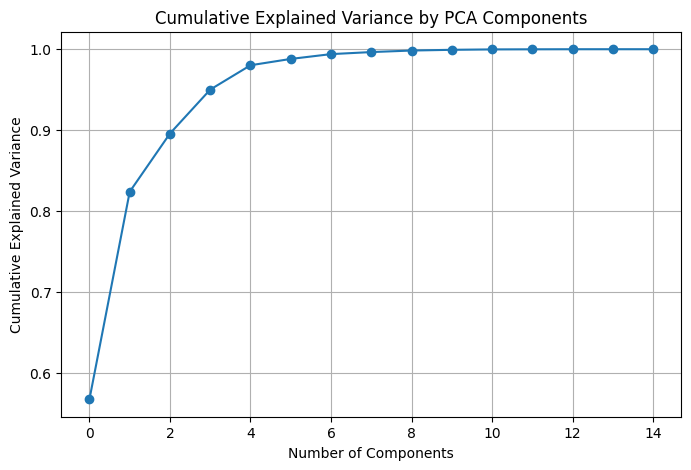


%90 açıklanan varyans için gerekli PCA bileşen sayısı: 4

PCA sonrası veri boyutu: (13611, 4)


In [9]:
pca = PCA()

X_pca = pca.fit_transform(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8,5))
plt.plot(cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

n_components_pca = np.argmax(cumulative_variance >= 0.9) + 1
print(f"\n%90 açıklanan varyans için gerekli PCA bileşen sayısı: {n_components_pca}")

pca = PCA(n_components=n_components_pca)
X_pca_reduced = pca.fit_transform(X_scaled)

print(f"\nPCA sonrası veri boyutu: {X_pca_reduced.shape}")


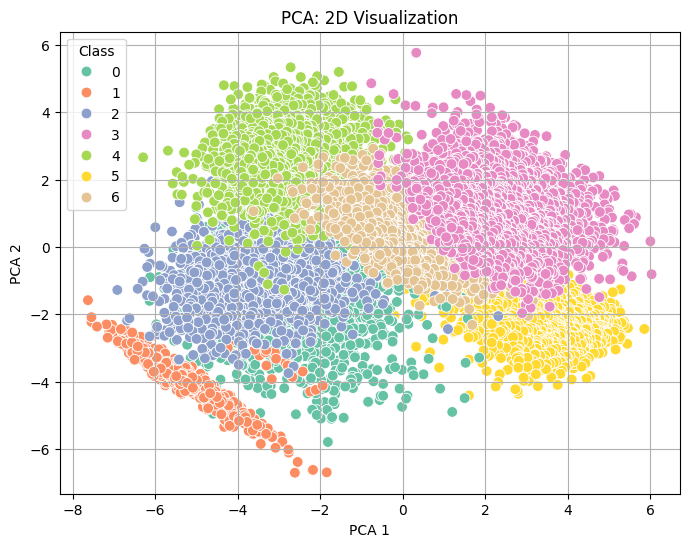

In [10]:
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca_2d[:,0], y=X_pca_2d[:,1], hue=y_encoded, palette='Set2', s=60)
plt.title('PCA: 2D Visualization')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Class')
plt.grid(True)
plt.show()


In [11]:
lda = LDA(n_components=3)

X_lda = lda.fit_transform(X_scaled, y_encoded)

print(f"\nLDA sonrası veri boyutu: {X_lda.shape}")



LDA sonrası veri boyutu: (13611, 3)


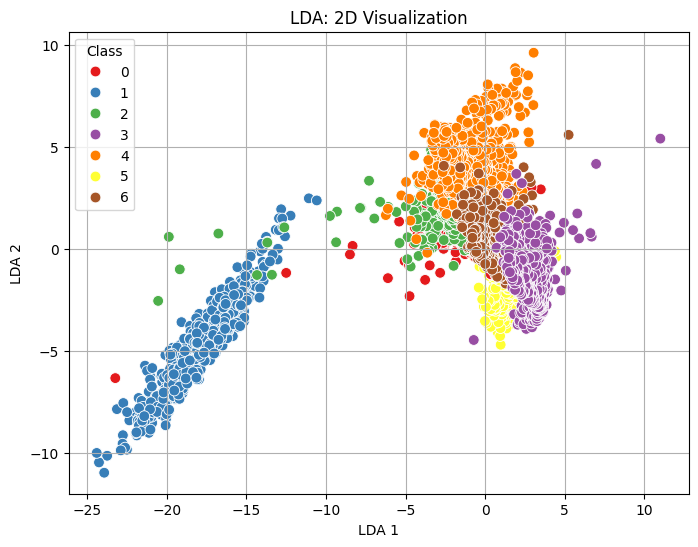

In [12]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_lda[:,0], y=X_lda[:,1], hue=y_encoded, palette='Set1', s=60)
plt.title('LDA: 2D Visualization')
plt.xlabel('LDA 1')
plt.ylabel('LDA 2')
plt.legend(title='Class')
plt.grid(True)
plt.show()


In [13]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def nested_cv(X, y, model, param_grid, outer_splits=5, inner_splits=3):
    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=42)
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=42)

    outer_accuracy = []
    outer_precision = []
    outer_recall = []
    outer_f1 = []

    for train_idx, test_idx in outer_cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]


        clf = GridSearchCV(model, param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1)
        clf.fit(X_train, y_train)

        best_model = clf.best_estimator_
        y_pred = best_model.predict(X_test)

        outer_accuracy.append(accuracy_score(y_test, y_pred))
        outer_precision.append(precision_score(y_test, y_pred, average='macro'))
        outer_recall.append(recall_score(y_test, y_pred, average='macro'))
        outer_f1.append(f1_score(y_test, y_pred, average='macro'))

    metrics = {
        'Accuracy': (np.mean(outer_accuracy), np.std(outer_accuracy)),
        'Precision': (np.mean(outer_precision), np.std(outer_precision)),
        'Recall': (np.mean(outer_recall), np.std(outer_recall)),
        'F1 Score': (np.mean(outer_f1), np.std(outer_f1))
    }

    return metrics


In [14]:


models_and_parameters = {
    'Logistic Regression': (
        LogisticRegression(max_iter=1000),
        {'C': [0.01, 0.1, 1, 10]}
    ),
    'Decision Tree': (
        DecisionTreeClassifier(),
        {'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10]}
    ),
    'Random Forest': (
        RandomForestClassifier(),
        {'n_estimators': [50, 100], 'max_depth': [5, 10, None]}
    ),
    'XGBoost': (
        XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
        {'n_estimators': [50, 100], 'max_depth': [3, 5, 7]}
    ),
    'Naive Bayes': (
        GaussianNB(),
        {}
    )
}


In [15]:

results = {}

data_versions = {
    'Raw': X_scaled,
    'PCA': X_pca_reduced,
    'LDA': X_lda
}

for version_name, X_version in data_versions.items():
    print(f"\n--- {version_name} veri üzerinde eğitim başlıyor ---")
    results[version_name] = {}

    for model_name, (model, param_grid) in models_and_parameters.items():
        print(f"Model: {model_name}")

        metrics = nested_cv(X_version, y_encoded, model, param_grid)
        results[version_name][model_name] = metrics



--- Raw veri üzerinde eğitim başlıyor ---
Model: Logistic Regression
Model: Decision Tree
Model: Random Forest
Model: XGBoost
Model: Naive Bayes

--- PCA veri üzerinde eğitim başlıyor ---
Model: Logistic Regression
Model: Decision Tree
Model: Random Forest
Model: XGBoost
Model: Naive Bayes

--- LDA veri üzerinde eğitim başlıyor ---
Model: Logistic Regression
Model: Decision Tree
Model: Random Forest
Model: XGBoost
Model: Naive Bayes


In [16]:
for version in results:
    print(f"\n\n===== {version} Data Results =====")
    for model in results[version]:
        print(f"\nModel: {model}")
        for metric, (mean, std) in results[version][model].items():
            print(f"{metric}: {mean:.4f} ± {std:.4f}")




===== Raw Data Results =====

Model: Logistic Regression
Accuracy: 0.9239 ± 0.0050
Precision: 0.9367 ± 0.0036
Recall: 0.9348 ± 0.0038
F1 Score: 0.9355 ± 0.0038

Model: Decision Tree
Accuracy: 0.9090 ± 0.0053
Precision: 0.9231 ± 0.0053
Recall: 0.9192 ± 0.0043
F1 Score: 0.9209 ± 0.0047

Model: Random Forest
Accuracy: 0.9256 ± 0.0046
Precision: 0.9380 ± 0.0036
Recall: 0.9350 ± 0.0034
F1 Score: 0.9363 ± 0.0035

Model: XGBoost
Accuracy: 0.9272 ± 0.0042
Precision: 0.9401 ± 0.0030
Recall: 0.9372 ± 0.0022
F1 Score: 0.9385 ± 0.0025

Model: Naive Bayes
Accuracy: 0.9006 ± 0.0065
Precision: 0.9120 ± 0.0055
Recall: 0.9110 ± 0.0047
F1 Score: 0.9109 ± 0.0050


===== PCA Data Results =====

Model: Logistic Regression
Accuracy: 0.8885 ± 0.0051
Precision: 0.8868 ± 0.0035
Recall: 0.8838 ± 0.0046
F1 Score: 0.8848 ± 0.0040

Model: Decision Tree
Accuracy: 0.8710 ± 0.0058
Precision: 0.8731 ± 0.0044
Recall: 0.8669 ± 0.0060
F1 Score: 0.8694 ± 0.0052

Model: Random Forest
Accuracy: 0.8916 ± 0.0056
Precision: 

In [17]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


n_classes = len(np.unique(y_encoded))


y_bin = label_binarize(y_encoded, classes=list(range(n_classes)))


def plot_roc_curve(model, X_test, y_test, model_name, data_version):
    y_score = model.predict_proba(X_test)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8,6))
    colors = plt.cm.get_cmap('Set1', n_classes)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors(i),
                 label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curves: {model_name} on {data_version} Data')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return roc_auc




########## Raw Veri Seti ##########

Model: Logistic Regression


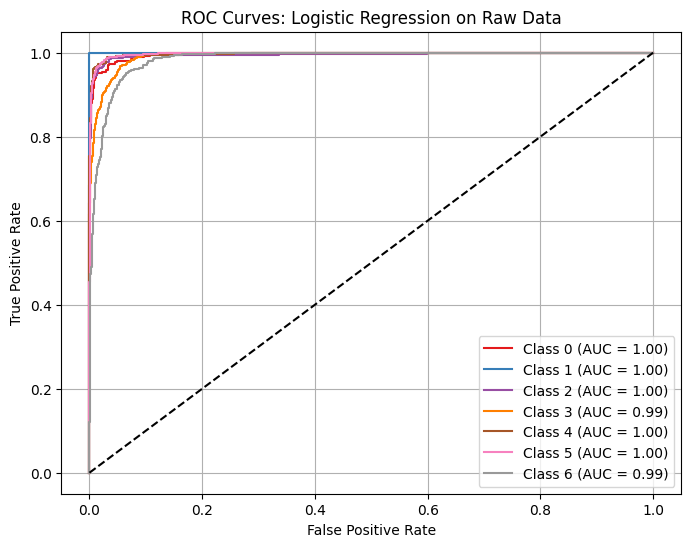


Model: Decision Tree


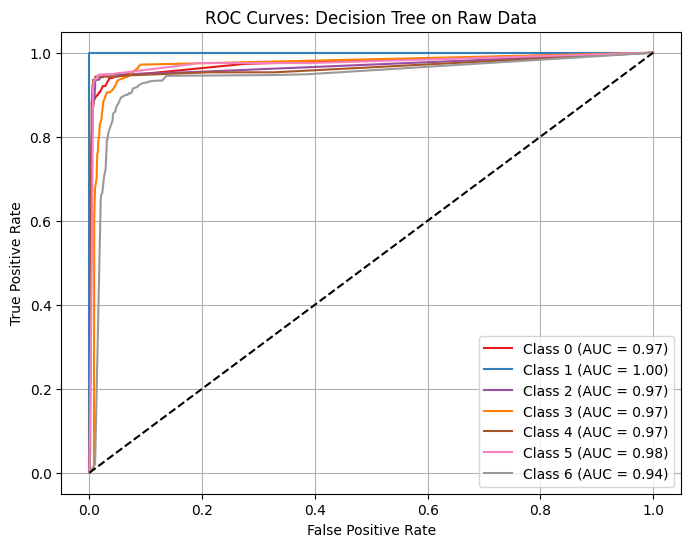


Model: Random Forest


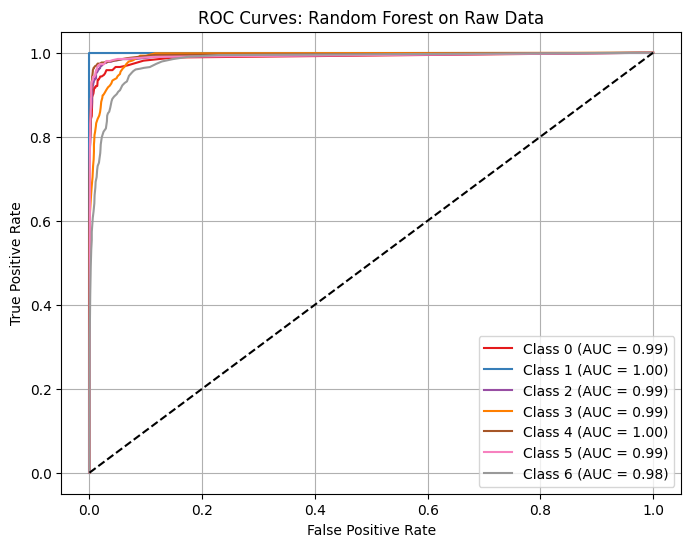


Model: XGBoost


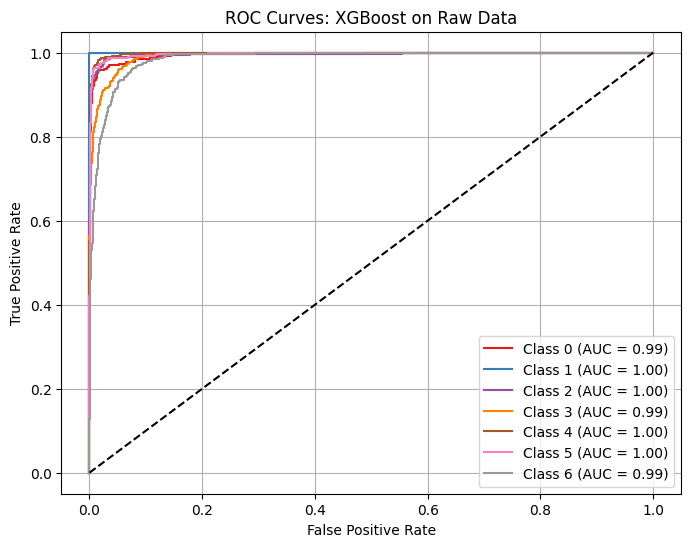


Model: Naive Bayes


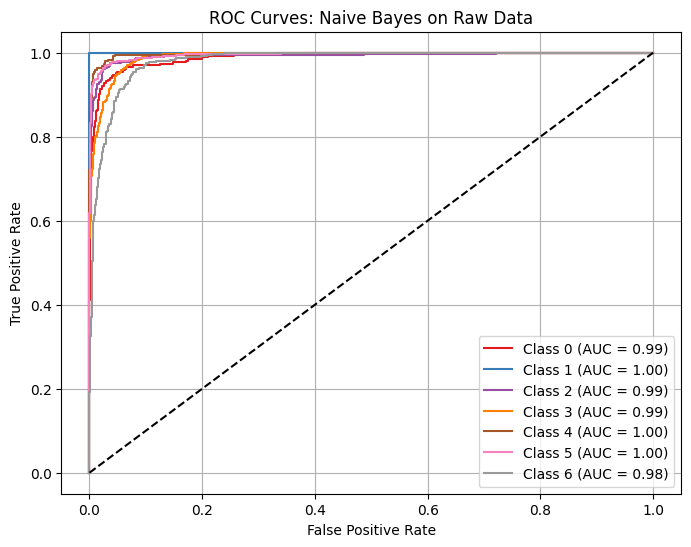



########## PCA Veri Seti ##########

Model: Logistic Regression


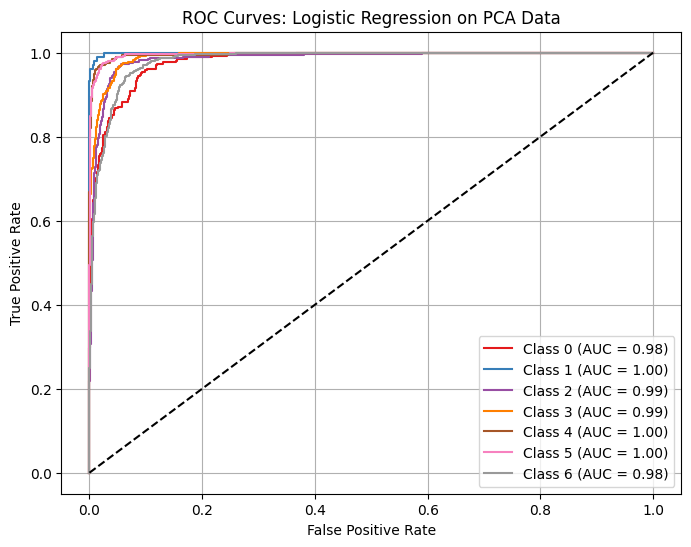


Model: Decision Tree


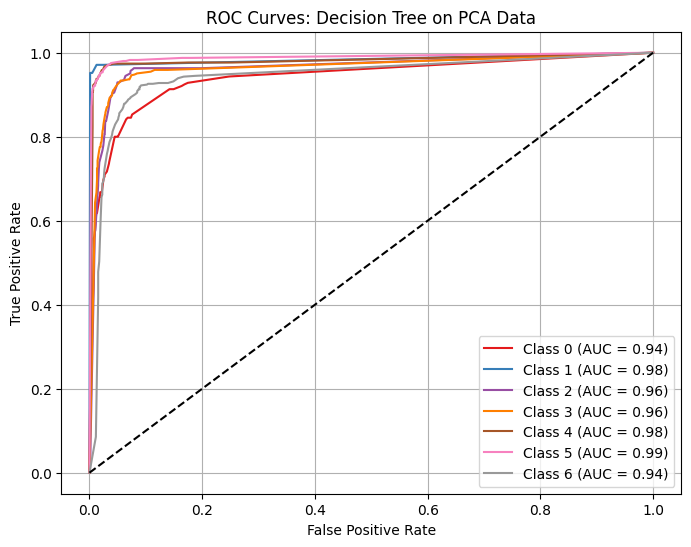


Model: Random Forest


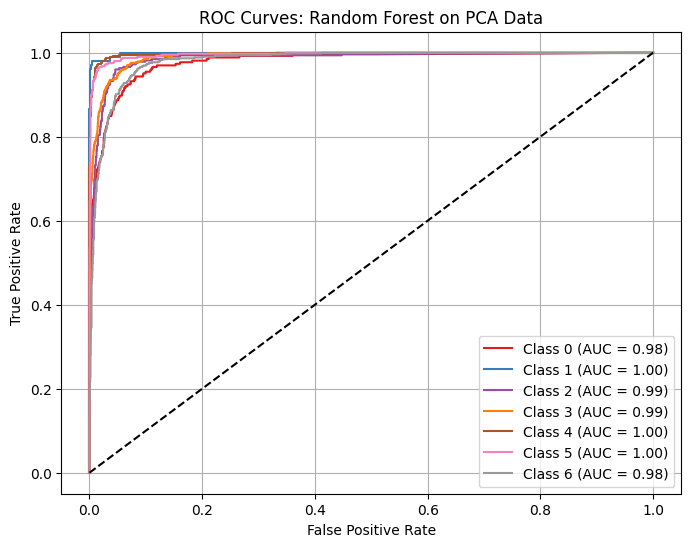


Model: XGBoost


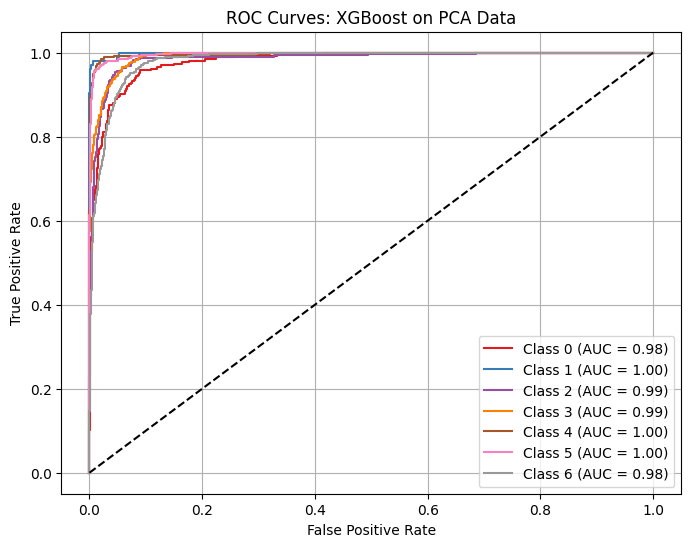


Model: Naive Bayes


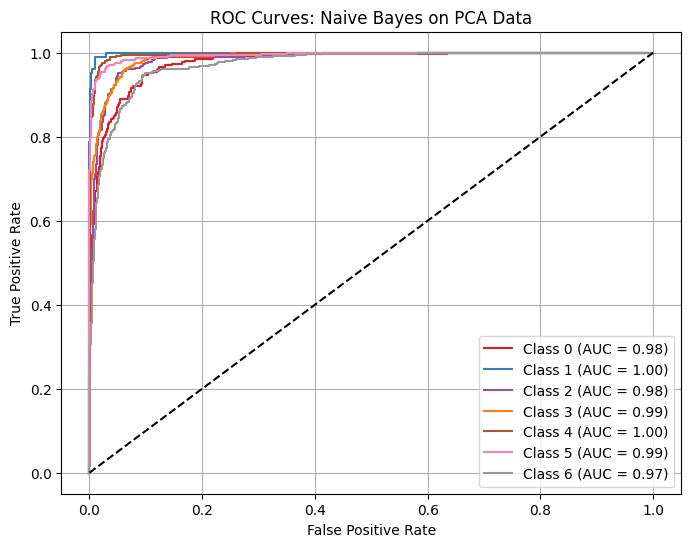



########## LDA Veri Seti ##########

Model: Logistic Regression


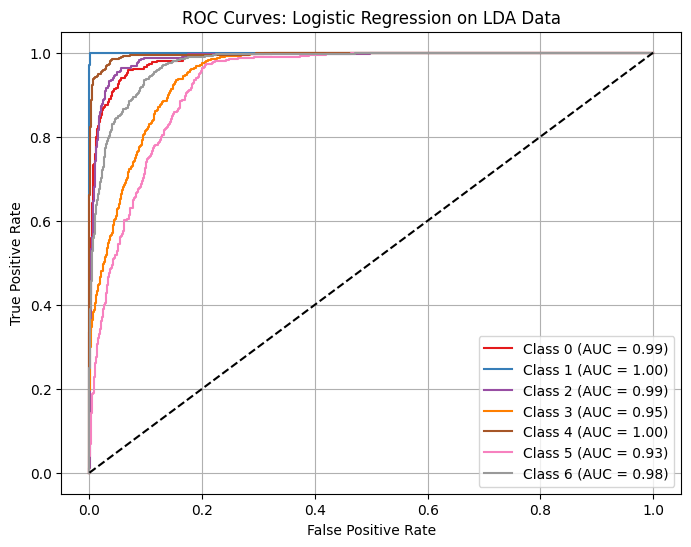


Model: Decision Tree


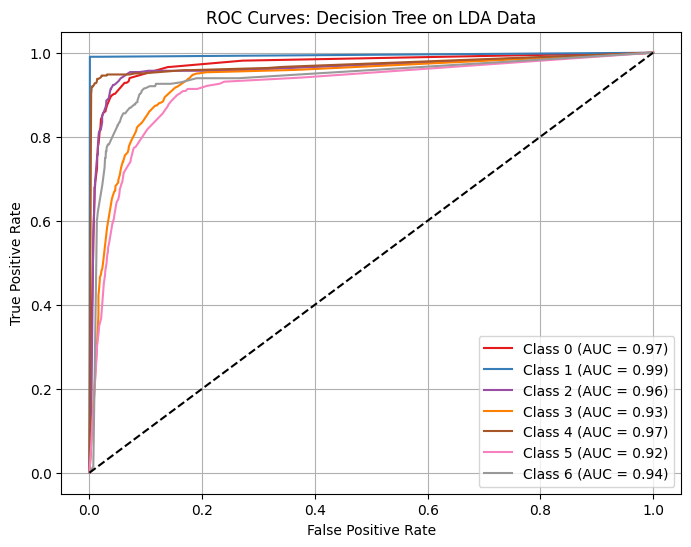


Model: Random Forest


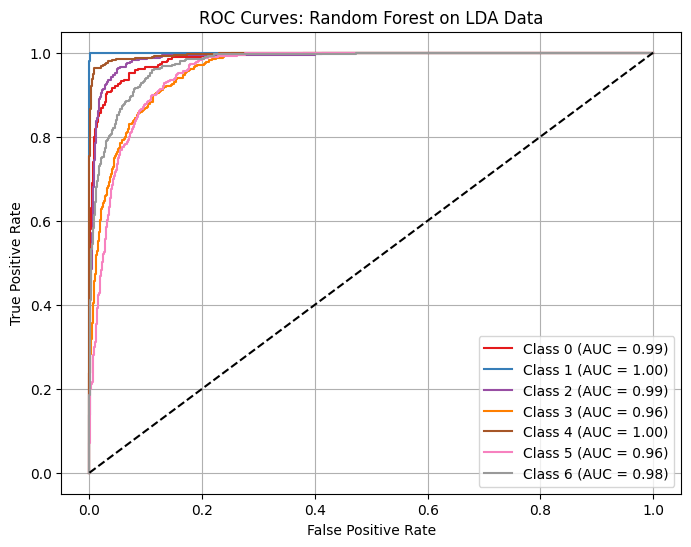


Model: XGBoost


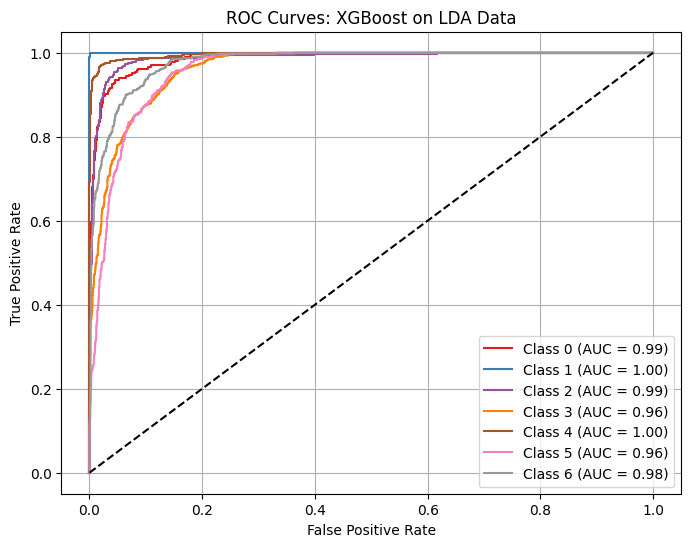


Model: Naive Bayes


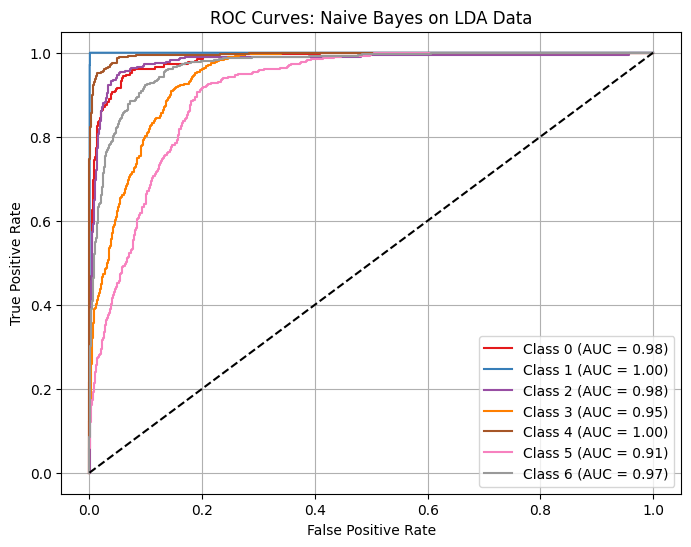

In [20]:
from sklearn.model_selection import train_test_split

# Test seti oranı
TEST_SIZE = 0.2

# Veriler
data_versions = {
    'Raw': X_scaled,
    'PCA': X_pca_reduced,
    'LDA': X_lda
}

for version_name, X_version in data_versions.items():
    print(f"\n\n########## {version_name} Veri Seti ##########")

    # Train/Test böl
    X_train, X_test, y_train, y_test = train_test_split(X_version, y_encoded, test_size=TEST_SIZE, random_state=42, stratify=y_encoded)
    y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

    for model_name, (model, param_grid) in models_and_parameters.items():
        print(f"\nModel: {model_name}")

        # Inner CV ile en iyi hiperparametreleri bul
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        clf = GridSearchCV(model, param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1)
        clf.fit(X_train, y_train)

        # Best model
        best_model = clf.best_estimator_

        # ROC eğrisi çiz
        roc_auc_scores = plot_roc_curve(best_model, X_test, y_test_bin, model_name, version_name)
